In [1]:
include("../ToolBox/ToolBox.jl")
using .ToolBox
import JLD
using Colors
import FileIO
import PyPlot

In [2]:
function db_scale_img(img , min , max)
    log_img = (10*log10.(img).-min)./(max-min)
    log_img[log_img.>1] .= 0.999
    log_img[log_img.<0] .= 0.001
    return log_img
end


function db_scale_img_diff(img1,img2 , min , max)
    log_img = 10*log10.(img1).-10*log10.(img2)
    log_img = (log_img.-min)./(max-min)
    log_img[log_img.>1] .= 0.999
    log_img[log_img.<0] .= 0.001
    return log_img
end

function scale_img(img , min , max)
    scale_img = (img.-min)./(max-min)
    scale_img[scale_img.>1] .= 0.999
    scale_img[scale_img.<0] .= 0.001
    return scale_img
end


function scale_img(img)
    min = minimum(reshape(img,:))
    max = maximum(reshape(img,:))
    return scale_img(img , min , max)
end

min_vv = -19
max_vv = 4

min_vh = -26
max_vh = -3

min_r = -10
max_r = 1;

min_h = -10
max_h = 100;

function add_mask(img,mask,color=(1,0,0))
    color = Colors.RGB{Float32}(color...)
    img_cop = copy(img)
    img_cop[mask] .= color
    return img_cop
end

function pretty_img(bands,min,max,k=1/1.4)
    pre = db_scale_img((bands[2] .+bands[3])./2,min,max) 
    co = db_scale_img(bands[1],min,max) 
    co = co.^k
    pre = pre.^k
    return Colors.RGB{Float32}.(pre,co,co);
end





pretty_img (generic function with 2 methods)

In [1]:
include("speciale_tools.jl")

_get_windows_nindex (generic function with 1 method)

In [2]:
import JLD
using Statistics
min_vv = -19
max_vv = 4

min_vh = -26
max_vh = -3

min_r = -10
max_r = 1;

min_h = -10
max_h = 100;

In [3]:
folder = "/home/data/simon/processed/66_fyn_winter2020/vejle" # desend

dem_nan = 40

co_gamma = JLD.load(joinpath(folder,"21VV_coher.jld"),"data")
pre_gamma = JLD.load(joinpath(folder,"23VV_coher.jld"),"data")

VV_paths = [joinpath(folder,string(i)*"VV_itens.jld") for i=1:3]
VV = [JLD.load(path,"data") for path in VV_paths]
VH_paths = [joinpath(folder,string(i)*"VH_itens.jld") for i=1:3]
VH = [JLD.load(path,"data") for path in VH_paths];
heights = JLD.load(joinpath(folder,"heights.jld"),"data").-dem_nan;

line_sample = JLD.load(joinpath(folder,"line_sample.jld"))
samples = collect(line_sample["samples"]) #[1:7:end]
lines = collect(line_sample["lines"]) #[1:2:end]
lut = JLD.load(joinpath(folder,"21_lut.jld"),"data");

In [4]:
#### Permant water

In [5]:
 folder = "/home/data/simon/result/segmenting/0Vejle"

"/home/data/simon/result/segmenting/0Vejle"

In [6]:
permant_water_VH = sum([10 .*log10.(band) .< -26 for band in VH]);
permant_water_VV = sum([10 .*log10.(band) .< -18 for band in VV]);
permanent_water = (1.5 .<permant_water_VV) .| (1.5 .<permant_water_VH);

### Plot the wate

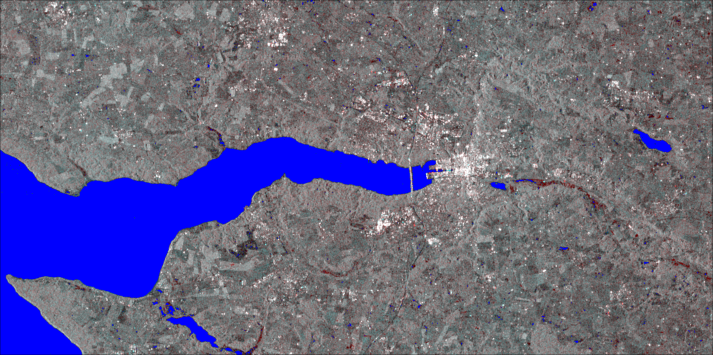

In [7]:
img = pretty_img(VV,min_vv,max_vv);
img = add_mask(img, permanent_water ,(0,0,1))

In [8]:
kernel = ones(2,2)
skimage_morph = PyCall.pyimport("skimage.morphology");
water_morph = skimage_morph.binary_closing(permanent_water,kernel)
water_morph = skimage_morph.binary_opening(water_morph,kernel);

In [9]:
water_contours = find_contours(water_morph)
close_contours!(water_contours)

In [29]:

data_dict = Dict{String,Any}("Number" => collect(1:length(water_contours)))

pixel_list = [poly_slize(VV[1],elem) for elem in water_contours]
data_dict["pixel_count"] = [length(elem) for elem in pixel_list]

for i in 1:length(VV)
    pixels_VV = [poly_slize(VV[i],elem) for elem in water_contours]
    data_dict["VV$(i)_mean_db"] = [10 .* log10.(mean(elem)) for elem in pixels_VV]
        
    pixels_VH = [poly_slize(VH[i],elem) for elem in water_contours]
    data_dict["VH$(i)_mean_db"] = [10 .* log10.(mean(elem)) for elem in pixels_VH]
end

In [32]:
data_dict["Polygon"] =  shapely_polygon.(contours_to_coordinates(water_contours,line_sample,lut));
save_shape_zip(geopandas_df(data_dict,"Polygon"),"final_test",folder)

Process(`rm -r /home/data/simon/result/segmenting/0Vejle/final_test`, ProcessExited(0))

In [42]:
skimage_meas = PyCall.pyimport("skimage.measure");


function find_contours(img,threshold = 0.5)
    temp = convert.(Float32,img)
    # Add hard boundary
    temp = hcat(zeros(size(temp)[1],1),temp,zeros(size(temp)[1],1))
    temp = vcat(zeros(1,size(temp)[2]),temp,zeros(1,size(temp)[2]))
    # Find contours
    contours = skimage_meas.find_contours(temp, 0.5)
    # The paddin os zeros make the python index of temp macth julia index om img
    return contours
end


function close_contours!(contours)
    not_closed = [sum(elem[1,:].==elem[end,:]) !=2 for elem in contours]
    if sum(not_closed) != 0
        println("$(sum(not_closed)) Polygons have been closed")
        contours[not_closed] = [vcat(elem,elem[1,:]') for elem in contours[not_closed]]
    end
end


function start_stop_step(range)
    if isa(range,StepRangeLen)
        start = range.ref.hi
        step = range.step.hi
        stop = range.step.hi* (range.len-1) + range.ref.hi
    elseif isa(range,StepRange)
        start = range.start
        step = range.step
        stop = range.stop
    end
    return start,step,stop
end

ndimage = PyCall.pyimport("scipy.ndimage")
function contours_to_coordinates(contours,line_sample,lut)
    contours_coords =  deepcopy(contours)
    
    start_line_contour ,step_line_contour ,stop_line_contour  = start_stop_step(line_sample["lines"])
    start_sample_contour ,step_sample_contour ,stop_sample_contour  = start_stop_step(line_sample["samples"])
    
    start_line_lut= lut["master_line"][1]
    step_line_lut= lut["master_line"][2]-lut["master_line"][1]
    
    start_sample_lut= lut["master_sample"][1]
    step_sample_lut= lut["master_sample"][2]-lut["master_sample"][1]
    
    start_sample_contour ,step_sample_contour ,stop_sample_contour  = start_stop_step(line_sample["samples"])

    lut_dims = (length(lut["master_line"]),length(lut["master_sample"]))
    lat_grid = reshape(lut["latitude"],lut_dims)
    lon_grid = reshape(lut["longitude"],lut_dims);
    
    for i in 1:length(contours)
        ## contours in line and sample
        index_1 = (contours[i][:,1].-1) .*step_line_contour .+start_line_contour
        index_2 = (contours[i][:,2].-1) .*step_sample_contour .+start_sample_contour
        
        ## countours in row, coulmn of lut grid
        index_1 = (index_1 .- start_line_lut)./step_line_lut
        index_2 = (index_2 .- start_sample_lut)./step_sample_lut

        contours_coords[i][:,1] = ndimage.map_coordinates(lat_grid,[index_1,index_2])
        contours_coords[i][:,2] = ndimage.map_coordinates(lon_grid,[index_1,index_2])
    end
    
    return contours_coords
end

shapely_geometry = PyCall.pyimport("shapely.geometry")
shapely_polygon(contour) = shapely_geometry.Polygon([(contour[i,2],contour[i,1]) for i in 1:size(contour)[1]])

pandas = PyCall.pyimport("pandas")
geopandas = PyCall.pyimport("geopandas")
function geopandas_df(data_dict,geometry_name,crs = "EPSG:4326")
    df = pandas.DataFrame(data_dict)
    gdf = geopandas.GeoDataFrame(df, geometry=geometry_name)
    gdf.crs = Dict("init" => crs)
    return gdf
end



function quicksave_shape(name,folder,mask,line_sample,lut,close=true)
    contours = find_contours(mask)
    if close
        close_contours!(contours)
    end
    contours = contours_to_coordinates(contours,line_sample,lut)
    contours = shapely_polygon.(contours)
    
    number = collect(1:length(contours))
    data_dict = Dict("Number" => number, "Polygon"=> contours)
    gdf = geopandas_df(data_dict,"Polygon")
    save_shape_zip(gdf,name,folder)
    return  gdf
end


function save_shape_zip(gdf,name,folder)
    
    dir_path = joinpath(folder,name)
    zip_path = dir_path*".zip"
    shapepath = joinpath(dir_path,name)*".shp"
    
    run(`mkdir $dir_path`) #Make folder
    gdf.to_file(shapepath) # save files
    run(`zip -q -j -r $zip_path $dir_path`)# zip files
    run(`rm -r $dir_path`) # remod files
end

save_shape_zip (generic function with 1 method)

In [159]:

"""
inpolygon(p, poly)
Modified from https://github.com/JuliaGeometry/PolygonOps.jl/blob/master/src/inpolygon.jl
check the membership of `p` in `poly`. Works invariant of winding order.
Returns:
- in = 1
- on = 1
- out = 0
Based on the algorithm by Hao and Sun :
https://www.researchgate.net/publication/328261689_Optimal_Reliable_Point-in-Polygon_Test_and_Differential_Coding_Boolean_Operations_on_Polygons

Modified from 
Copyright (c) 2019 steve <kd2cca@gmail.com>

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""



function inpolygon(p, poly)
    k = 0

    xp = p[1]
    yp = p[2]

    PT = eltype(p)

    for i = 1:size(poly)[1]-1
        v1 = poly[i,2] - yp
        v2 = poly[i+1,2] - yp

        if v1 < zero(PT) && v2 < zero(PT) || v1 > zero(PT) && v2 > zero(PT)
            continue
        end

        u1 = poly[i,1] - xp
        u2 = poly[i+1,1] - xp

        f = (u1 * v2) - (u2 * v1)

        if v2 > zero(PT) && v1 <= zero(PT)
            if f > zero(PT)
                k += 1
            elseif iszero(f)
                return true
            end
        elseif v1 > zero(PT) && v2 <= zero(PT)
            if f < zero(PT)
                k += 1
            elseif iszero(f)
                return true
            end
        elseif iszero(v2) && v1 < zero(PT)
            iszero(f) && return true
        elseif iszero(v1) && v2 < zero(PT)
            iszero(f) && return true
        elseif iszero(v1) && iszero(v2)
            if u2 <= zero(PT) && u1 >= zero(PT)
                return true
            elseif u1 <= zero(PT) && u2 >= zero(PT)
                return 
            end
        end
    end

    iszero(k % 2) && return false
    return true
end


function poly_slize(data,polygon)

    dims = size(data)

    index_in, window, window_dims = _get_windows_nindex(polygon,dims) 
    
    data_slice = data[window...]
    
    return reshape(data_slice,:)[index_in]
end


function poly_to_mask(polygon_list,dims)
    
    mask = zeros(Int64,dims...)
    
    for i = 1 : length(polygon_list)
        index_in, window, window_dims = _get_windows_nindex(polygon_list[i],dims) 
        mask[window...] .= reshape(index_in,window_dims).*i
    end

    return mask
end

function _get_windows_nindex(polygon,dims) 
    dims = size(data)

    row_max = minimum([ceil(Int64,maximum(polygon[:,1])),dims[1]])
    row_min = maximum([floor(Int64,minimum(polygon[:,1])),1])

    col_max = minimum([ceil(Int64,maximum(polygon[:,2])),dims[2]])
    col_min = maximum([floor(Int64,minimum(polygon[:,2])),1])


    window = (row_min:row_max,col_min:col_max)
    window_dims = (row_max-row_min+1,col_max-col_min+1)
    
    col, row = Misc.flatten(window...)
    index_in = [inpolygon([col[i],row[i]],polygon) for i =1:(window_dims[1]*window_dims[2])]
    return index_in, window, window_dims
end
    

_get_windows_nindex (generic function with 1 method)

In [147]:
mask = zeros(Int64,dims...)

2×3 Array{Int64,2}:
 0  0  0
 0  0  0

In [160]:
mask_test = poly_to_mask(contours_test,size(VV[1]));

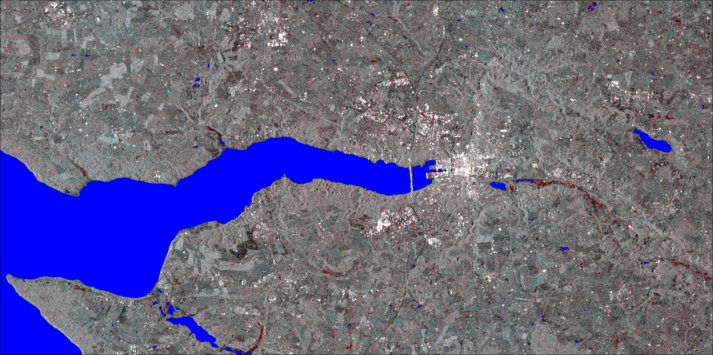

In [161]:
img = pretty_img(VV,min_vv,max_vv);
img = add_mask(img, mask_test.>0,(0,0,1))

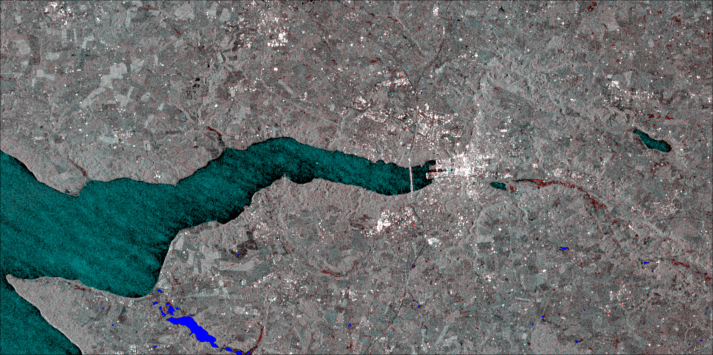

In [162]:
img = pretty_img(VV,min_vv,max_vv);
img = add_mask(img, mask_test.>50,(0,0,1))

In [72]:
contours_test = find_contours(water_morph);
polygon = contours_test[4]

11×2 Array{Float64,2}:
 8.5  606.0
 8.5  605.0
 8.0  604.5
 7.0  604.5
 6.0  604.5
 5.5  605.0
 5.5  606.0
 6.0  606.5
 7.0  606.5
 8.0  606.5
 8.5  606.0

In [149]:
VV_poly = [poly_slize(VV[1],elem) for elem in contours_test];
VV_mean_db = [10 .* log10.(sum(elem)/length(elem)) for elem in VV_poly]

94-element Array{Float64,1}:
 -17.03294907783955 
 -17.205351001814844
 -19.869802355771622
 -20.328820591099092
 -17.451044828263935
 -18.134409846687834
 -18.586531823274324
 -18.014675644203553
 -15.611267769498623
 -19.18723206655193 
 -20.22999245142891 
 -17.27803233010458 
 -15.815967893633688
   ⋮                
 -16.506091791132064
 -19.70131109083272 
 -16.512391479782977
 -18.39650440748957 
 -17.357335536735363
 -17.249605568766523
 -15.385710270836427
 -16.925002569542208
 -17.717230581404554
 -17.166684663145418
 -18.1973496478285  
 -17.421878025140117

In [146]:
 [length(elem) for elem in VV_poly]

94-element Array{Int64,1}:
  4
  6
 11
  6
 34
 12
 21
 11
  6
  6
  6
  4
  4
  ⋮
  4
  4
  4
  4
 20
  4
 13
 62
  4
 81
 13
  6

In [80]:
points = [[6,605],[6,608],[6,604.5]]
[inpolygon(elem, polygon) for elem in points]

3-element Array{Bool,1}:
 1
 0
 1

In [139]:
polygon = contours_test[2]
data = VV[1]
dims = size(data)

row_max = minimum([ceil(Int64,maximum(polygon[:,1])),dims[1]])
row_min = maximum([floor(Int64,minimum(polygon[:,1])),1])

col_max = minimum([ceil(Int64,maximum(polygon[:,2])),dims[2]])
col_min = maximum([floor(Int64,minimum(polygon[:,2])),1])


window = (row_min:row_max,col_min:col_max)
window_dims = (row_max-row_min+1,col_max-col_min+1) 

(3, 5)

In [142]:
col, row = Misc.flatten(window...)
index_in = [inpolygon([col[i],row[i]],polygon) for i =1:(window_dims[1]*window_dims[2])]
data_slice = data[window...]
pixels = reshape(data_slice,:)[index_in]

6-element Array{Float64,1}:
 0.029116091905769186
 0.013158770774091489
 0.02223946021633815 
 0.008822309507769941
 0.027796356614169137
 0.013053876149207009

In [129]:
size(data)

(709, 1425)

In [132]:
contours_test[2]

11×2 Array{Float64,2}:
 2.5  617.0
 2.5  616.0
 2.5  615.0
 2.0  614.5
 1.0  614.5
 0.5  615.0
 0.5  616.0
 0.5  617.0
 1.0  617.5
 2.0  617.5
 2.5  617.0

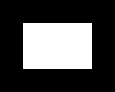

In [124]:
Colors.Gray.(reshape(index_in,window_dims))

In [39]:
water_contours = find_contours_v2(water_morph)
#close_contours!(water_contours)
water_contours = contours_to_coordinates(water_contours,line_sample,lut);
water_contours = shapely_polygon.(water_contours);

In [40]:
water_type = [0 for i in 1:length(water_contours)]
name = ["permant water" for i in 1:length(water_contours)]
number = collect(1:length(water_contours));
data_dict = Dict("Number" => number, "Name" => name, 
                "Water type"=> water_type, "Polygon"=> water_contours)

Dict{String,Array{T,1} where T} with 4 entries:
  "Water type" => [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, …
  "Polygon"    => PyCall.PyObject[PyObject <shapely.geometry.polygon.Polygon ob…
  "Number"     => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  85, 86, 87, 88, 89, 90, 91…
  "Name"       => ["permant water", "permant water", "permant water", "permant …

In [41]:
save_shape_zip(geopandas_df(data_dict,"Polygon"),"contour_v2",folder)

Process(`rm -r /home/data/simon/result/segmenting/0Vejle/contour_v2`, ProcessExited(0))

In [28]:
file_name = "water_test_quick"
quicksave_shape(file_name,folder,water_morph,line_sample,lut,true)

,Polygon,Number
0,"POLYGON ((9.70584 55.77780, 9.70577 55.77752, ...",1
1,"POLYGON ((9.67255 55.78077, 9.67247 55.78050, ...",2
2,"POLYGON ((9.66959 55.78103, 9.66974 55.78086, ...",3
3,"POLYGON ((9.67626 55.77853, 9.67662 55.77850, ...",4
4,"POLYGON ((9.46060 55.79683, 9.46097 55.79680, ...",5
...,...,...
89,"POLYGON ((9.68125 55.60331, 9.68162 55.60328, ...",90
90,"POLYGON ((9.68899 55.60261, 9.68936 55.60258, ...",91
91,"POLYGON ((9.67691 55.60206, 9.67713 55.60217, ...",92
92,"POLYGON ((9.66800 55.60325, 9.66837 55.60321, ...",93


In [29]:
3+5

8

In [15]:
water_contours = skimage_meas.find_contours(convert.(Float32,water_morph), 0.5);
#water_polygons = [skimage_meas.approximate_polygon(elem, 2) for elem in water_contours];

In [ ]:
close_contours!(water_contours)

In [79]:
water_contours.+1

MethodError: MethodError: no method matching +(::Array{Float64,2}, ::Int64)
Closest candidates are:
  +(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:529
  +(!Matched::Complex{Bool}, ::Real) at complex.jl:297
  +(!Matched::Missing, ::Number) at missing.jl:115
  ...

In [81]:
convert.(Float32,water_morph)

709×1425 Array{Float32,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0

### Get lat lon for the contours

In [55]:
test.

ErrorException: type StepRange has no field ref

In [16]:
contours_coords =  deepcopy(water_contours)

offset_line = line_sample["lines"].ref.hi
step_line = line_sample["lines"].step.hi

offset_sample = line_sample["samples"].ref.hi
step_sample = line_sample["samples"].step.hi

lut_dims = (length(lut["master_line"]),length(lut["master_sample"]))
lat_grid = reshape(lut["latitude"],lut_dims)
lon_grid = reshape(lut["longitude"],lut_dims);

for i in 1:length(water_contours)
    ## contours in line and sample
    index_1 = water_contours[i][:,1] .*step_line .+offset_line
    index_2 = water_contours[i][:,2] .*step_sample .+offset_sample
    ## countours in row, coulmn of lut grid
    index_1 = (index_1 .- lut["master_line"][1])./(lut["master_line"][2]-lut["master_line"][1])
    index_2 = (index_2 .- lut["master_sample"][1])./(lut["master_sample"][2]-lut["master_sample"][1])
    
    contours_coords[i][:,1] = ndimage.map_coordinates(lat_grid,[index_1,index_2])
    contours_coords[i][:,2] = ndimage.map_coordinates(lon_grid,[index_1,index_2])
end


In [17]:
shapely_geometry = PyCall.pyimport("shapely.geometry")

PyObject <module 'shapely.geometry' from '/home/data/simon/anaconda3/envs/sentinel/lib/python3.8/site-packages/shapely/geometry/__init__.py'>

In [18]:
polygons = [[(elem[i,2],elem[i,1]) for i in 1:size(elem)[1]]  for elem in contours_coords]
polygons = [shapely_geometry.Polygon(elem) for elem in polygons];

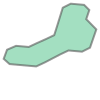

In [19]:
polygons[7]

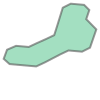

In [20]:
test = polygons[7]

In [20]:
water_type = [0 for i in 1:length(polygons)]
name = ["permant water" for i in 1:length(polygons)]
number = collect(1:length(polygons));
pandas_dict = Dict("Number" => number, "Name" => name, 
                "Water type"=> water_type, "Polygon"=> polygons)

Dict{String,Array{T,1} where T} with 4 entries:
  "Water type" => [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, …
  "Polygon"    => PyCall.PyObject[PyObject <shapely.geometry.polygon.Polygon ob…
  "Number"     => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  85, 86, 87, 88, 89, 90, 91…
  "Name"       => ["permant water", "permant water", "permant water", "permant …

In [21]:
pandas = PyCall.pyimport("pandas")
geopandas = PyCall.pyimport("geopandas")

PyObject <module 'geopandas' from '/home/data/simon/anaconda3/envs/sentinel/lib/python3.8/site-packages/geopandas/__init__.py'>

In [22]:
df = pandas.DataFrame(pandas_dict)
gdf = geopandas.GeoDataFrame(df, geometry="Polygon")
gdf.crs = Dict("init" => "EPSG:4326")

Dict{String,String} with 1 entry:
  "init" => "EPSG:4326"

In [23]:
gdf.to_file(joinpath(folder,"water_test.shp"))